# Исследование по поиску клиентов с неоптимальными тарифами

В исследовании заказчиком является провайдер виртуальной телефонии, его клиенты − колл-центры.

Представлены следующие тарифы:
<table>
    <tr><th> <th><th> Тариф А <th><th> Тариф B <th><th> Тариф С <th><tr>
    <tr><td> Ежемесячная плата за тариф <td><td> 4000 ₽ <td><td> 2000 ₽ <td><td> 1000 ₽ <td><tr>
    <tr><td> Дополнительная ежемесячная плата за каждого оператора <td><td> 50 ₽ <td><td> 150 ₽ <td><td> 300 ₽ <td><tr>
    <tr><td> Все входящие <td><td> бесплатно <td><td> бесплатно <td><td> бесплатно <td><tr>
    <tr><td> Исходящие звонки внутри сети, включённые в тариф <td><td> 2000 минут <td><td> 500 минут <td><td> 0 минут <td><tr>
    <tr><td> Исходящие звонки внутри сети, цена сверх лимита <td><td> 0.1 ₽/мин <td><td> 0.15 ₽/мин <td><td> 0.3 ₽/мин <td><tr>
    <tr><td> Исходящие звонки, кроме внутренних <td><td> 0.3 ₽/мин <td><td> 0.5 ₽/мин <td><td> 0.7 ₽/мин <td><tr>
<table>

**Цель проекта**:\
Для повышения лояльности клиентов и уменьшения потенциального оттока из-за переплаты, нужно проанализировать тарифы компании и понять:
- насколько они подходят колл-центрам;
- насколько для наших клиентов будет выгодна смена тарифа;
- какую долю клиентов целесообразно переводить;
- сильно ли изменится выручка после оптимизации тарифов.

**План декомпозиции исследования:**

1. [Предобработка данных](#step_1)
    * [Проверка на дубликаты и пропуски в данных](#step_1_1)
    * [Проверка типов данных и их приведение](#step_1_2)
    * [Объединим таблицы и добавим столбцы для расчёта выручки](#step_1_3)
2. [Исследовательский анализ](#step_2)
    * [Поиск активных клиентов](#step_2_1)
    * [Подсчёт выручки по активным клиентам](#step_2_2)
    * [Выручка и среднее арифметическое в разрезе тарифов](#step_2_3)
    * [Корректировка неоптимальных тарифов и подсчёт выручки по результату](#step_2_4)
3. [Статистический анализ](#step_3)
    * [Проверим различие выручки на тарифных планах A и B](#step_3_1)
    * [Проверим различие выручки до и после оптимизации тарифов](#step_3_2)
4. [Выводы и предложения по сохранению выручки после оптимизации тарифов у клиентов](#step_4)

In [1]:
# загрузка библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import datetime as dt

In [2]:
# загрузка датасетов
clients = pd.read_csv('/telecom_clients.csv')
calls = pd.read_csv('/telecom_dataset.csv')

In [3]:
# снимаем ограничение на количество столбцов
pd.set_option('display.max_columns', None)

# снимаем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

# игнорируем предупреждения
pd.set_option('chained_assignment', None)

In [4]:
# общее знакомство с данными
display(
    clients.sample(5),
    clients.describe(),
    clients.info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


,user_id,tariff_plan,date_start
136,168008,C,2019-10-09
526,168558,B,2019-10-30
547,167310,B,2019-09-11
395,167994,C,2019-10-09
347,167035,C,2019-08-29


,user_id
count,732.000000
mean,167431.927596
std,633.810383
min,166373.000000
25%,166900.750000
50%,167432.000000
75%,167973.000000
max,168606.000000


None

In [5]:
# общее знакомство с данными
display(
    calls.sample(5),
    calls.describe(),
    calls.info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
7932,166658,2019-08-21 00:00:00+03:00,out,False,890410.0,True,2,0,34
43931,168021,2019-10-24 00:00:00+03:00,in,False,NaN,True,7,0,114
50230,168252,2019-11-01 00:00:00+03:00,out,False,940588.0,True,1,0,2
29397,167235,2019-11-14 00:00:00+03:00,in,False,NaN,True,3,0,158
19623,166983,2019-11-24 00:00:00+03:00,out,False,901884.0,False,14,3169,3436


,user_id,operator_id,calls_count,call_duration,total_call_duration
count,53902.000000,45730.000000,53902.000000,53902.000000,53902.000000
mean,167295.344477,916535.993002,16.451245,866.684427,1157.133297
std,598.883775,21254.123136,62.917170,3731.791202,4403.468763
min,166377.000000,879896.000000,1.000000,0.000000,0.000000
25%,166782.000000,900788.000000,1.000000,0.000000,47.000000
50%,167162.000000,913938.000000,4.000000,38.000000,210.000000
75%,167819.000000,937708.000000,12.000000,572.000000,902.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000


None

В датасете по клиентам:
- тип данных нужно сменить только у столбца с датой подключения;
- пропусков нет.

В датасете звонков:
- нужно сменить тип данных в столбце даты. У `operator_id` сменить тип на целочисленный для удобства;
- есть пропуски в `operator_id` и `internal` - идентификатор оператора нужен для дальнейшего исследования по расчёту выручки, также как и определить внешний или внутренний был звонок, проверим на следующем этапе;
- также на следующем шаге проверим дубликаты.

## Предобработка данных <a id="step_1"></a>

### Проверка на дубликаты и пропуски в данных <a id="step_1_1"></a>

#### Проверим строки на полные дубликаты

In [6]:
calls.loc[calls.duplicated()]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
28,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34
44,166377,2019-08-14 00:00:00+03:00,out,False,880026.0,False,10,1567,1654
45,166377,2019-08-14 00:00:00+03:00,in,False,NaN,True,1,0,3
51,166377,2019-08-15 00:00:00+03:00,out,False,880026.0,False,11,1413,1473
...,...,...,...,...,...,...,...,...,...
53869,168601,2019-11-25 00:00:00+03:00,in,False,952914.0,False,7,1229,1282
53874,168601,2019-11-26 00:00:00+03:00,in,False,952914.0,False,4,539,562
53875,168601,2019-11-26 00:00:00+03:00,in,False,NaN,True,3,0,35
53885,168603,2019-11-20 00:00:00+03:00,out,False,959118.0,True,3,0,89


4900 строк задвоилось - удалим дубликаты и сохраним только первые вхождения.

In [7]:
calls = calls.drop_duplicates(ignore_index=True)

#### Проверим строки, где возникли пропуски в столбце `internal`

In [8]:
print('Всего пропусков в столбце:', calls.loc[(calls['internal'].isna()), 'user_id'].count())
print('Пропусков по исходящим звонкам:', calls.loc[(calls['internal'].isna())&(calls['direction']=='out'), 'user_id'].count())

Всего пропусков в столбце: 110
Пропусков по исходящим звонкам: 2


Проверим были ли минуты по исходящим звонкам

In [9]:
calls.loc[(calls['internal'].isna())&(calls['direction']=='out')]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
19099,167016,2019-10-23 00:00:00+03:00,out,NaN,NaN,True,3,0,196
46717,168291,2019-11-28 00:00:00+03:00,out,NaN,NaN,True,3,0,93


По исходящим звонкам минут для тарификации не было.\
Следовательно данные пропуски не отразятся на расчётах - заполним пропуски значением `True`

In [10]:
calls['internal'] = calls['internal'].fillna(True)

#### Проверим пропуски в столбце `operator_id`

In [11]:
print(
    'Всего пропусков в столбце:',
    calls.loc[(calls['operator_id'].isna()), 'user_id'].count(),'\n'
    'Пропусков с принятым звонком:',
    calls.loc[(calls['operator_id'].isna())&(calls['is_missed_call']==False), 'user_id'].count(),'\n'
    'Пропусков с ненулевой продолжительностью:',
    calls.loc[(calls['internal'].isna())&(calls['call_duration']!=0), 'user_id'].count()
)

Всего пропусков в столбце: 7456 
Пропусков с принятым звонком: 113 
Пропусков с ненулевой продолжительностью: 0


Т.к. количество операторов влияет на стоимость услуг - заполним пропуски идентификаторами текущих операторов, которые работают в соответствующих колл-центрах

In [12]:
calls['operator_id'] = (
    calls
    .groupby('user_id', group_keys=False)['operator_id']
    .apply(lambda x: x.fillna(method='bfill').fillna(method='ffill'))
)

In [13]:
calls.loc[(calls['operator_id'].isna())]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
5973,166554,2019-08-09 00:00:00+03:00,in,True,NaN,True,2,0,8
6694,166584,2019-08-16 00:00:00+03:00,in,False,NaN,True,2,0,4
20924,167077,2019-09-06 00:00:00+03:00,in,False,NaN,True,1,0,2
20925,167077,2019-09-07 00:00:00+03:00,in,False,NaN,True,1,0,1
20926,167077,2019-09-09 00:00:00+03:00,in,False,NaN,True,1,0,2
...,...,...,...,...,...,...,...,...,...
48700,168446,2019-10-31 00:00:00+03:00,in,False,NaN,True,1,0,2
48701,168446,2019-11-08 00:00:00+03:00,in,False,NaN,True,1,0,3
48796,168490,2019-11-13 00:00:00+03:00,in,False,NaN,True,1,0,2
48797,168490,2019-11-26 00:00:00+03:00,in,False,NaN,True,1,0,0


Пропуски остались только у колл-центров, в которых не было ни одного принятого звонка - заполним фиктивным значением, чтобы не возникло ошибок в дальнейшей части исследования.

In [14]:
calls.loc[(calls['operator_id'].isna()), 'operator_id'] = 999999

### Проверка типов данных и их приведение <a id="step_1_2"></a>

Меняем тип у столбцов с датами

In [15]:
calls['date'] = pd.to_datetime(calls['date']).dt.date
calls['date'] = pd.to_datetime(calls['date'])

clients['date_start'] = pd.to_datetime(clients['date_start'])

Меняем тип данных у столбца `operator_id`

In [16]:
calls['operator_id'] = calls['operator_id'].astype('int')

In [17]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49002 entries, 0 to 49001
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              49002 non-null  int64         
 1   date                 49002 non-null  datetime64[ns]
 2   direction            49002 non-null  object        
 3   internal             49002 non-null  bool          
 4   operator_id          49002 non-null  int32         
 5   is_missed_call       49002 non-null  bool          
 6   calls_count          49002 non-null  int64         
 7   call_duration        49002 non-null  int64         
 8   total_call_duration  49002 non-null  int64         
dtypes: bool(2), datetime64[ns](1), int32(1), int64(4), object(1)
memory usage: 2.5+ MB


### Объединим таблицы и добавим столбцы для расчёта выручки <a id="step_1_3"></a>

Для расчёта выручки объединим таблицы и добавим дополнительные столбцы:
- месяц тарифа;
- количество уникальных операторов по каждому пользователю в конкретный месяц тарифа;
- звонки переведём в минуты для удобства расчёта выручки.

#### Объединяем таблицы

In [18]:
display(
    calls.shape,
    clients.shape
)

df = clients.merge(calls, on='user_id', how='left')
df.shape

(49002, 9)

(732, 3)

(49427, 11)

#### Добавляем тарифный месяц
Столбец поможет расчитать звонки, оказанные услуги и выручку помесячно.\
Если у колл-центров не было совершённых звонков - укажем месяц начала тарифа.

In [19]:
get_billing_month = (
    lambda row:
    row['date_start'].month if (
        (row['date'].month - row['date_start'].month <= 1 and row['date'].day < row['date_start'].day)
        or (row['date'].month == row['date_start'].month)
    )
    else (
        row['date'].month if (
            (row['date'].day >= row['date_start'].day)
            or (row['date'].month == row['date_start'].month and row['date'].day < row['date_start'].day)
        )
        else (
            row['date_start'].month if row['date'] is pd.NaT
            else row['date'].month - 1
             )
    )
)

In [20]:
df['month'] = df.apply(lambda row: get_billing_month(row), axis=1)

#### Пересчитаем звонки из секунд в минуты
Т.к. тарификация идёт за каждую минуту - округляем в большую сторону.

In [21]:
df['call_duration'] = np.ceil(df['call_duration'] / 60)

#### Сгруппируем данные по идентификатору колл-центра, месяцу тарифа, а также по направлению и сети звонка

In [22]:
res = (
    df.groupby(['user_id', 'month', 'direction', 'internal'], as_index=False)
    .agg(
        current_tariff=('tariff_plan', 'first'),
        calls_duration=('call_duration', 'sum')
    )
)

res = res.set_index(['user_id', 'month'])

#### Теперь добавим количество уникальных операторов по идентификатору колл-центра и месяцу тарифа 

In [23]:
res['operators_count'] = df.groupby(['user_id', 'month'], as_index=True).agg(operators_count=('operator_id', 'nunique'))
res

direction internal current_tariff  calls_duration  \
user_id month                                                     
166377  8            in    False              B            27.0   
        8           out    False              B          1102.0   
        8           out     True              B             1.0   
        9            in    False              B            36.0   
        9           out    False              B          1455.0   
...                 ...      ...            ...             ...   
168603  10           in    False              B             0.0   
        10          out    False              B            17.0   
168606  10           in    False              C            12.0   
        10          out    False              C            15.0   
        10          out     True              C            61.0   

               operators_count  
user_id month                   
166377  8                    5  
        8                    5  
        8                    5  
        9                    4  
        9                    4  
...                        ...  
168603  10                   1  
        10                   1  
168606  10                   1  
        10                   1  
        10                   1  

[1743 rows x 5 columns]

#### Развернём данные по минутам звонков
Сделаем 4 столбца с отдельными показателями по каждому направлению:
- исходящие внутри сети
- исходящие вне сети
- входящие внутри сети
- входящие вне сети

In [24]:
res['calls_out_internal'] = res.loc[(res['direction']=='out')&(res['internal']==True), 'calls_duration']
res['calls_out_external'] = res.loc[(res['direction']=='out')&(res['internal']==False), 'calls_duration']
res['calls_in_internal'] = res.loc[(res['direction']=='in')&(res['internal']==True), 'calls_duration']
res['calls_in_external'] = res.loc[(res['direction']=='in')&(res['internal']==False), 'calls_duration']

res = res.reset_index()
res = (
    res
    .groupby(['user_id', 'month'], as_index=False)
    .agg(
        current_tariff=('current_tariff', 'first'),
        operators_count=('operators_count', 'first'),
        calls_out_internal=('calls_out_internal', 'first'),
        calls_out_external=('calls_out_external', 'first'),
        calls_in_internal=('calls_in_internal', 'first'),
        calls_in_external=('calls_in_external', 'first')
    ).fillna(0)
)

res

,user_id,month,current_tariff,operators_count,calls_out_internal,calls_out_external,calls_in_internal,calls_in_external
0,166377,8,B,5,1.0,1102.0,0.0,27.0
1,166377,9,B,4,0.0,1455.0,0.0,36.0
2,166377,10,B,5,1.0,1385.0,0.0,45.0
3,166377,11,B,4,2.0,1327.0,0.0,55.0
4,166391,8,C,2,0.0,0.0,1.0,4.0
...,...,...,...,...,...,...,...,...
777,168583,10,B,2,0.0,0.0,0.0,21.0
778,168598,10,C,1,0.0,0.0,1.0,76.0
779,168601,10,C,2,0.0,415.0,0.0,147.0
780,168603,10,B,1,0.0,17.0,0.0,0.0


#### Промежуточный вывод
Скорректировали типы данных, избавились от дубликатов и заполнили пропуски с расчётом, чтобы это не сказалось на расчёте выручки. Также добавили столбцы для дальнейшего анализа.\
В итоге получили таблицу, где в каждой строке данные сгруппированы по пользователю и месяцу тарифа.

Переходим к нахождению активных клиентов и расчёту выручки.

## Исследовательский анализ <a id="step_2"></a>

In [25]:
display(
    calls['date'].min(),
    calls['date'].max()
)

Timestamp('2019-08-02 00:00:00')

Timestamp('2019-11-28 00:00:00')

### Поиск активных клиентов <a id="step_2_1"></a>

Нам предоставлены данные за период со 2 августа по 28 ноября 2019 года.\
В ходе исследования мы должны проверить оптимальность тарифов у актуальных колл-центров - возьмём клиентов, которые совершали звонки в октябре-ноябре.

In [26]:
recent_users = res.loc[
    (res['month'].isin([10, 11]))&
    ((res['calls_out_internal']>0)|(res['calls_out_external']>0)|(res['calls_in_internal']>0)|(res['calls_in_external']>0)),
    'user_id'
]
actual_df = res[res['user_id'].isin(recent_users)]
print('Количество активных пользователей:', actual_df['user_id'].nunique())

Количество активных пользователей: 259


Отобрали активных пользователей за последние два месяца и взяли по ним показатели за весь период - переходим к расчёту выручки

### Подсчёт выручки по активным клиентам <a id="step_2_2"></a>

Сделаем функцию, которая рассчитает выручку по текущему тарифу и оптимальному тарифу, а также разницу между ними

In [27]:
def calculate_revenue(row):
    base_rates = {'A': 4000, 'B': 2000, 'C': 1000}
    operator_costs = {'A': 50, 'B': 150, 'C': 300}
    external_call_rates = {'A': 0.3, 'B': 0.5, 'C': 0.7}
    internal_call_package = {'A': 2000, 'B': 500, 'C': 0}
    internal_call_exceed_rates = {'A': 0.1, 'B': 0.15, 'C': 0.3}

    # Расчет выручки по текущему тарифу
    base_fee = base_rates[row['current_tariff']]
    operators_fee = row['operators_count'] * operator_costs[row['current_tariff']]
    external_fee = row['calls_out_external'] * external_call_rates[row['current_tariff']]
    internal_fee = (
        max(0, row['calls_out_internal'] - internal_call_package[row['current_tariff']]) *
        internal_call_exceed_rates[row['current_tariff']]
    )
    
    
    current_revenue = base_fee + operators_fee + external_fee + internal_fee

    # Находим самый выгодный тариф
    optimal_tariff = min(['A', 'B', 'C'], key=lambda t: calculate_min_revenue(row, t))

    # Рассчитываем разницу между текущим тарифом и самым выгодным
    tariff_difference = current_revenue - calculate_min_revenue(row, optimal_tariff)

    # Рассчитываем сумму выручки по самому выгодному тарифу
    optimal_revenue = calculate_min_revenue(row, optimal_tariff)

    return pd.Series([current_revenue, optimal_tariff, optimal_revenue, tariff_difference])

def calculate_min_revenue(row, tariff):
    base_rates = {'A': 4000, 'B': 2000, 'C': 1000}
    operator_costs = {'A': 50, 'B': 150, 'C': 300}
    external_call_rates = {'A': 0.3, 'B': 0.5, 'C': 0.7}
    internal_call_package = {'A': 2000, 'B': 500, 'C': 0}
    internal_call_exceed_rates = {'A': 0.1, 'B': 0.15, 'C': 0.3}

    base_fee = base_rates[tariff]
    operators_fee = row['operators_count'] * operator_costs[tariff]
    external_fee = row['calls_out_external'] * external_call_rates[tariff]
    internal_fee = max(0, row['calls_out_internal'] - internal_call_package[tariff]) *internal_call_exceed_rates[tariff]
    
    total_revenue = base_fee + operators_fee + external_fee + internal_fee
    return total_revenue

data = actual_df.copy()

data[['current_revenue', 'optimal_tariff', 'optimal_revenue', 'tariff_difference']] = data.apply(calculate_revenue, axis=1)

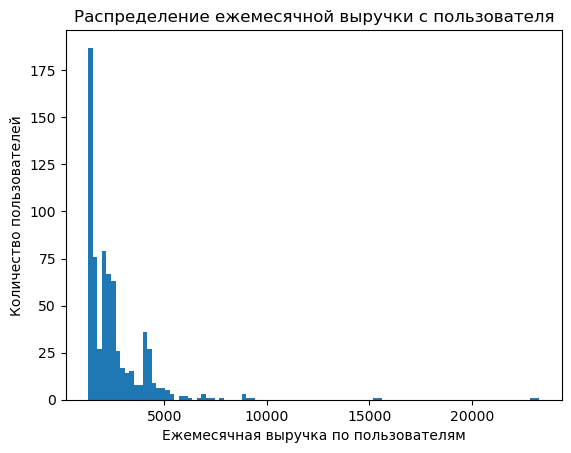

In [28]:
plt.hist(data['current_revenue'], bins=100)
plt.title('Распределение ежемесячной выручки с пользователя')
plt.xlabel('Ежемесячная выручка по пользователям')
plt.ylabel('Количество пользователей')
plt.show()

По графику видно, что большая часть активных клиентов располагаются на тарифе C - самый большой пик около 1000 рублей.\
Также заметны пики около 2000 и 4000 рублей - по тарифам B и A соответственно.\
При этом есть клиенты, которые платят ежемесячно более 20000 рублей.

### Выручка и среднее арифметическое в разрезе тарифов <a id="step_2_3"></a>

Проверим соотношение выручки между тарифами

,current_tariff,revenue_amount,revenue_mean,revenue_median,users_count
0,A,419151.2,5305.711392,4202.8,29
1,B,684266.7,2693.963386,2445.5,92
2,C,676968.1,1844.599728,1484.1,138


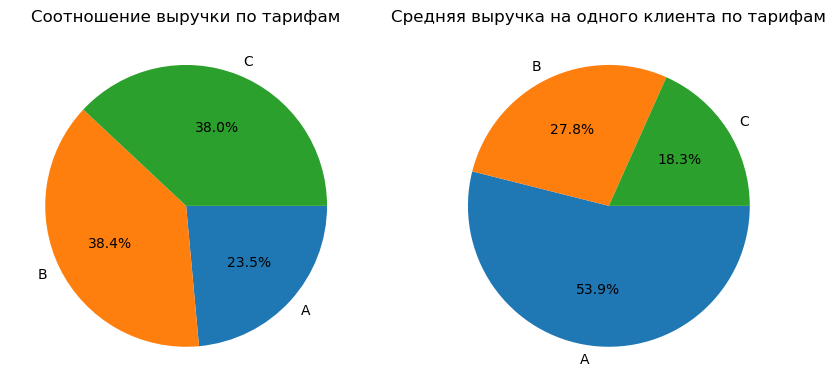

In [29]:
revenue_by_tariff = (
    data
    .groupby('current_tariff', as_index=False)
    .agg(
        revenue_amount=('current_revenue', 'sum'),
        revenue_mean=('current_revenue', 'mean'),
        revenue_median=('current_revenue', 'median'),
        users_count=('user_id', 'nunique')
    )
)

display(revenue_by_tariff)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].pie(revenue_by_tariff['revenue_amount'],
        labels = revenue_by_tariff['current_tariff'], 
        autopct='%1.1f%%',
        counterclock=False)
axs[0].set_title('Соотношение выручки по тарифам')

axs[1].pie(revenue_by_tariff['revenue_amount']/revenue_by_tariff['users_count'],
        labels = revenue_by_tariff['current_tariff'], 
        autopct='%1.1f%%',
        counterclock=False)
axs[1].set_title('Средняя выручка на одного клиента по тарифам')
plt.show()

Видим, что тариф В приносит 38,4% выручки, тариф С - 38%, а на тариф А приходится 23,5%.\
При этом средняя выручка отдельного клиента на тарифе А составляет 53,9%, когда на тарифе С - только 18,3%.

### Корректировка неоптимальных тарифов и подсчёт выручки по результату <a id="step_2_4"></a>

Посмотрим как обстоят дела с переплатами по отдельным тарифам.

,current_tariff,revenue_amount,optimal_amount,diff_to_optimal,diff_mean,diff_median
0,A,419151.2,280827.75,138323.45,1750.929747,2240.00
1,B,684266.7,538286.05,145980.65,574.726969,663.65
2,C,676968.1,661853.70,15114.40,41.183651,0.00


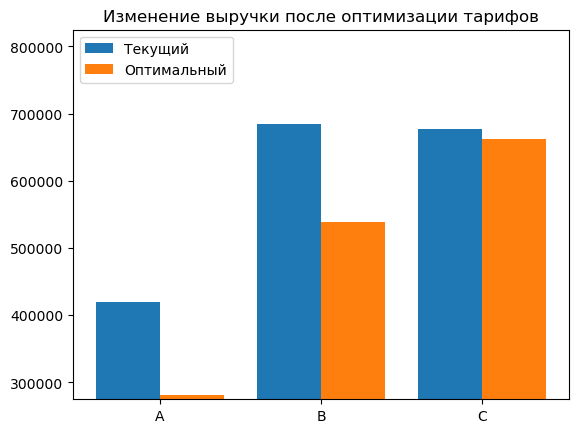

In [30]:
difference_by_tariff = (
    data
    .groupby('current_tariff', as_index=False)
    .agg(
        revenue_amount=('current_revenue', 'sum'),
        optimal_amount=('optimal_revenue', 'sum'),
        diff_to_optimal=('tariff_difference', 'sum'),
        diff_mean=('tariff_difference', 'mean'),
        diff_median=('tariff_difference', 'median'),
    )
)
display(difference_by_tariff)

fig, ax = plt.subplots()
index = np.arange(3)
bw = 0.4
plt.title('Изменение выручки после оптимизации тарифов')
plt.bar(index - bw/2, difference_by_tariff['revenue_amount'], bw, label='Текущий')
plt.bar(index + bw/2, difference_by_tariff['optimal_amount'], bw, label='Оптимальный')
plt.xticks(index, difference_by_tariff['current_tariff'].unique())
plt.ylim([275000, 825000])
plt.legend(loc=2)
plt.show()

По графику видим, что самые большие переплаты у абонентов тарифов А и В - около 140000 рублей на каждый тариф.\
А вот на тарифе С практически нет клиентов с переплатой.

### Промежуточные выводы

- тариф В приносит 38,4% выручки, тариф С - 38%, а на тариф А приходится 23,5%;
- при этом средняя выручка отдельного клиента на тарифе А составляет 53,9%, тариф В - 27,8%, а на тарифе С - только 18,3%.
- на тарифе С - 138 активных абонентов и практически нет переплат;
- переплаты на тарифе А и В около 140 тысяч рублей на всех клиентов каждого тарифа. При этом клиентов на тарифе А меньше в 3 раза, чем на В - 29 к 92 соответственно.

## Статистический анализ <a id="step_3"></a>

### Проверим различие выручки на тарифных планах A и B <a id="step_3_1"></a>

<p>Введем нулевую и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Выручка между тарифами А и В статистически не различается}\\
   H_1 :\text{В выручке между тарифами А и В статистически есть различие}
 \end{cases}
\end{equation*}$

In [31]:
revenue_A = data[data['current_tariff'] == 'A']['current_revenue']
revenue_B = data[data['current_tariff'] == 'B']['current_revenue']

print(f"Средняя выручка с клиента тарифа А: {revenue_A.mean():.1f} рублей")
print(f"Средняя выручка с клиента тарифа В: {revenue_B.mean():.1f} рублей")

alpha = 0.05
results = st.ttest_ind(revenue_A, revenue_B, equal_var=False, alternative='two-sided')
print(f'p-value: {results.pvalue}')
 
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу - есть статистическое различие в выручке между тарифами А и В')
else:
    print('Нет оснований отвергнуть нулевую гипотезу - нет статистического различия в выручке между тарифами А и В')

Средняя выручка с клиента тарифа А: 5305.7 рублей
Средняя выручка с клиента тарифа В: 2694.0 рублей
p-value: 3.901542777954485e-09
Отвергаем нулевую гипотезу - есть статистическое различие в выручке между тарифами А и В


### Проверим различие выручки до и после оптимизации тарифов <a id="step_3_2"></a>

<p>Введем нулевую и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Выручка до и после оптимизации статистически не различается}\\
   H_1 :\text{В выручке до и после оптимизации статистически есть различие}
 \end{cases}
\end{equation*}$

In [32]:
current_revenue = data['current_revenue']
optimal_revenue = data['optimal_revenue']

print(f"Выручка до оптимизации тарифов: {current_revenue.sum():.1f} рублей")
print(f"Выручка после оптимизации тарифов: {optimal_revenue.sum():.1f} рублей")

alpha = 0.05
results = st.ttest_rel(current_revenue, optimal_revenue)
print(f'p-value: {results.pvalue}')
 
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу - есть статистическое различие в выручке до и после оптимизации тарифов')
else:
    print('Нет оснований отвергнуть нулевую гипотезу - нет статистического различия в выручке до и после оптимизации тарифов')

Выручка до оптимизации тарифов: 1780386.0 рублей
Выручка после оптимизации тарифов: 1480967.5 рублей
p-value: 2.3118388190978487e-54
Отвергаем нулевую гипотезу - есть статистическое различие в выручке до и после оптимизации тарифов


### Выводы по тестам

По двум тестам подтвердили статистически значимые различия:
- клиенты на тарифе А платят больше, чем на тарифе В;
- выручка после оптимизации тарифов станет меньше.

## Выводы и предложения по сохранению выручки после оптимизации тарифов у клиентов <a id="step_4"></a>

### Выводы
Нам были предоставлены данные за период со 2 августа по 28 ноября 2019 года.
Клиенты провайдера виртуальной телефонии, колл-центры, подключены к одному из трёх тарифов: А, В и С.

В исследовательском анализе обнаружили следующие особенности:
- тариф В приносит 38,4% выручки, тариф С - 38%, а на тариф А приходится 23,5%;
- при этом средняя выручка отдельного клиента на тарифе А составляет 53,9%, тариф В - 27,8%, а на тарифе С - только 18,3%.
- на тарифе С - 138 активных абонентов и практически нет переплат;
- переплаты на тарифе А и В около 140 тысяч рублей на всех клиентов каждого тарифа. При этом клиентов на тарифе А меньше в 3 раза, чем на В - 29 к 92 соответственно.

С помощью тестов доказали, что есть статистические различия:
- средняя выручка с пользователя тарифа А отличается от тарифа В - клиенты тарифа А в среднем платят больше;
- выручка до и после оптимизации тарифов различается - после оптимизации выручка станет меньше.

### Предложения
При оптимизации тарифов будем поддерживать баланс между потерей выручки и сдерживании возможного оттока клиентов.

#### Тариф С:
На тарифе С практически нет переплат - на 138 активных клиентов выходит лишь 15114,40 рублей.\
Клиенты с переплатами используют услуги сверх тарифа, что указывает на потенциальный рост их бизнеса.\
**Решение: всем клиентам с переплатой предложить смену тарифа на оптимальный.**

#### Тариф В:
На 92 активных клиентов приходится 145980,65 рублей переплаты.\
В среднем за месяц переплата составляет 574,73 рубля на абонента, а медиана - 663,65 рублей.\
**Решение: 25% клиентам с самыми большими по размеру переплатами предложить перейти на более выгодный тариф. Т.к. медиана больше среднего значения - больших переплат по количеству не так много и потеря выручки будет не так значительна.**

#### Тариф А:
На 29 активных клиентов приходится 138323,45 рублей переплаты.\
В среднем за месяц переплата составляет 1750,93 рубля на абонента, а медиана - 2240 рублей.\
**Решение: т.к. здесь медиана также больше среднего значения, поступим как и с клиентами на тарифе В - 25% клиентам с самыми большими по размеру переплатами предложить перейти на более выгодный тариф.**